# Obtain Results for models
This file has the code to run and obtain the outputs of both the YOLO and UNet Models using the trained model

To obtain the results, you may change the path and enter a list of test_input image ids. The test input image ids must be a part of the test images present in the SeaTurtle Dataset. The image ids must also be present in the resultant records of the metadata_splits.csv file after performing 'split_open = 'test'

# YOLO
Run the following cells to obtain the model's predicted results for the YOLO Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Function to access public folder
def access_public_folder(folder_url):
    """
    Get direct access to a public Google Drive folder

    Args:
        folder_url: Public sharing URL of the Google Drive folder
    """
    # Extract folder ID
    if 'folders' in folder_url:
        folder_id = folder_url.split('folders/')[-1].split('?')[0]
    else:
        raise ValueError("Invalid folder URL format")

    # The folder will be accessible in "Shared with me" directory
    folder_path = f"/content/drive/MyDrive/Shared with me/{folder_id}"

    print(f"Folder accessible at: {folder_path}")
    return folder_path

In [ ]:
folder_url = "https://drive.google.com/drive/folders/1-4TPJ3x-masg9mfWIA2AZZC4r-XWWbNu?usp=sharing"
mount_point = "/content/my_project"

# Mount the folder
access_public_folder(folder_url)

Folder accessible at: /content/drive/MyDrive/Shared with me/1-4TPJ3x-masg9mfWIA2AZZC4r-XWWbNu


'/content/drive/MyDrive/Shared with me/1-4TPJ3x-masg9mfWIA2AZZC4r-XWWbNu'

In [ ]:
pip install "tensorflow<=2.13"

In [ ]:
!pip install ultralytics -q
!pip install pycocotools -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.0/887.0 kB 30.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.13.0 which is incompatible.


In [ ]:
import os
import json
from pycocotools.coco import COCO
import shutil
from datetime import datetime
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
from ultralytics import YOLO
from pathlib import Path


base_dir = '/content/drive/MyDrive/turtles/turtles-data/'

# Path to coco annotations obtained from downloaded dataset
coco_path = os.path.join(base_dir, 'annotations.json')

with open(coco_path) as f:
    coco_data = json.load(f)
coco = COCO(coco_path)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
loading annotations into memory...
Done (t=4.83s)
creating index...
index created!


In [ ]:
# Change the file paths and test_img_ids to run the code for specific images
# Directory Paths
yolo_model_path = base_dir + '12_11/yolo_model_12_11.pt'
test_img_path = base_dir + '12_11/yolo_time_aware_split/test/images'

# List of IDs for which results are to be predicted
test_img_ids = [7878, 8234]


# Create Time Aware Splits for ids using Metadata
metadata_df = pd.read_csv(base_dir+'metadata_splits.csv')

# Create train DataFrame by filtering metadata for the 'split_open' on train, test and validation data
test_df = metadata_df[metadata_df['split_open'] == 'test']
sample_test_df = test_df[test_df['id'].isin(test_img_ids)]



image 1/1 /content/drive/MyDrive/turtles/turtles-data/12_11/yolo_time_aware_split/test/images/aPUsIpzHru.jpeg: 448x640 1 turtle, 2 flippers, 1 head, 83.0ms
Speed: 11.1ms preprocess, 83.0ms inference, 1126.4ms postprocess per image at shape (1, 3, 448, 640)


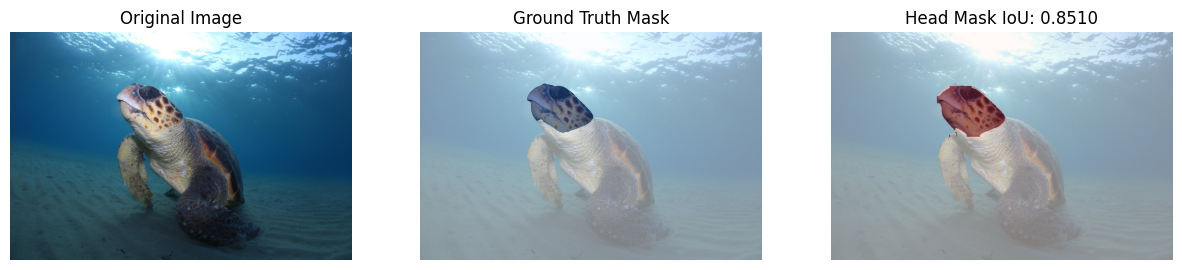

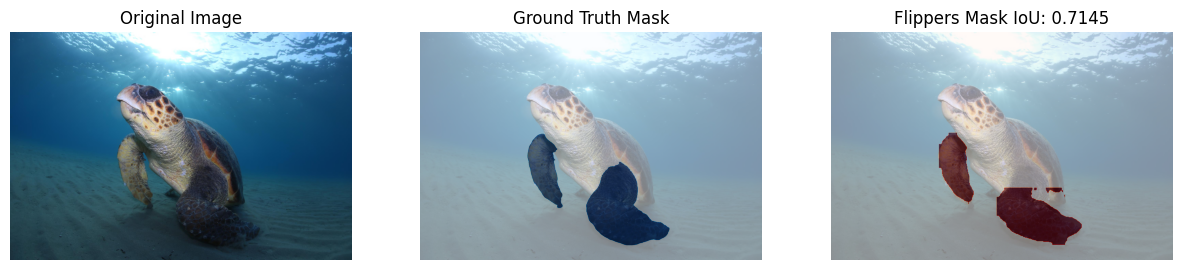

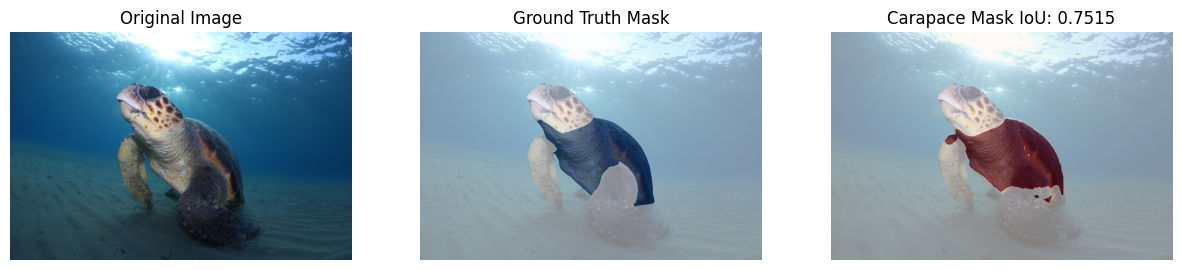

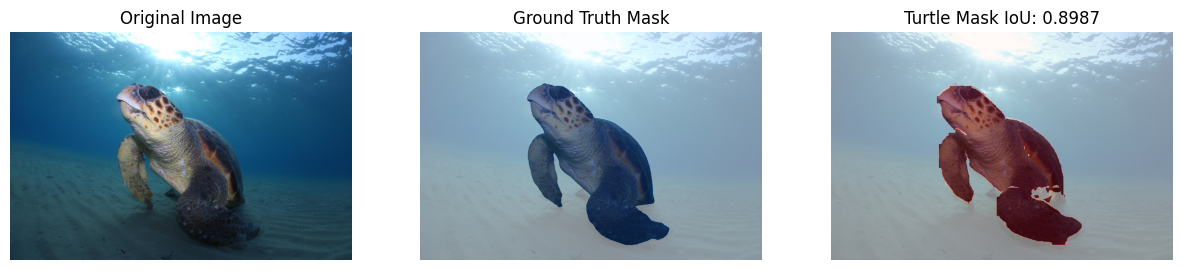

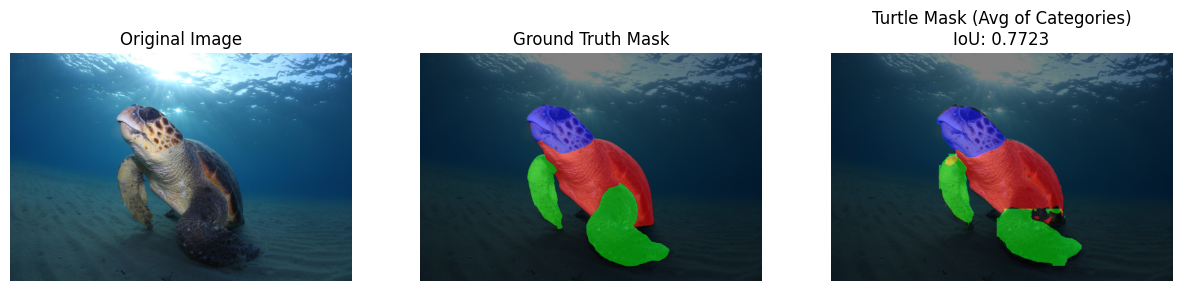

Processed Image Id: 7878; Head IoU = 0.8510, Flippers IoU = 0.7145, Carapace IoU = 0.7515, Turtle IoU = 0.8987, Avg IoU (3 categories) 0.7723

image 1/1 /content/drive/MyDrive/turtles/turtles-data/12_11/yolo_time_aware_split/test/images/iOHuUaZNtV.jpeg: 448x640 1 turtle, 2 flippers, 1 head, 16.6ms
Speed: 3.4ms preprocess, 16.6ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


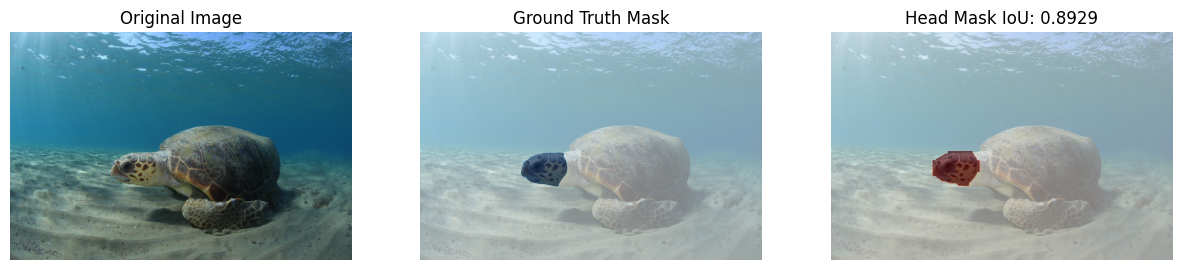

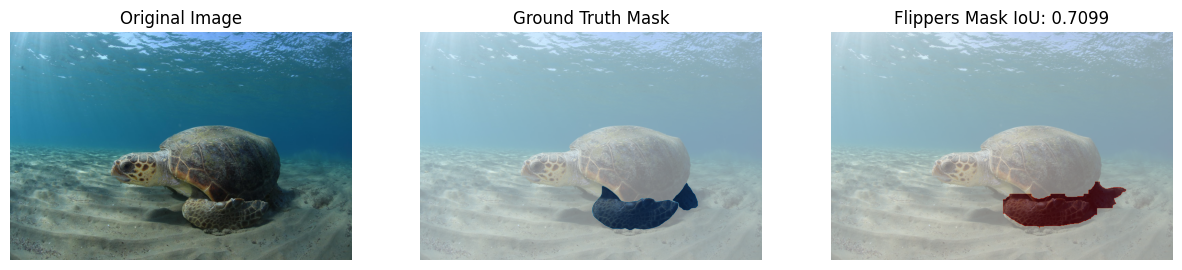

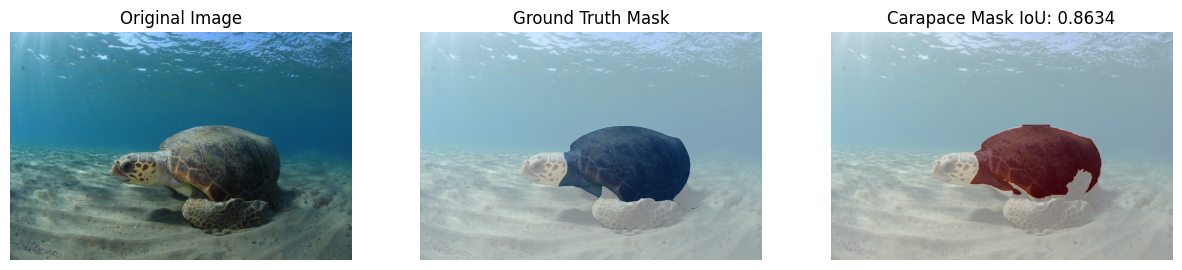

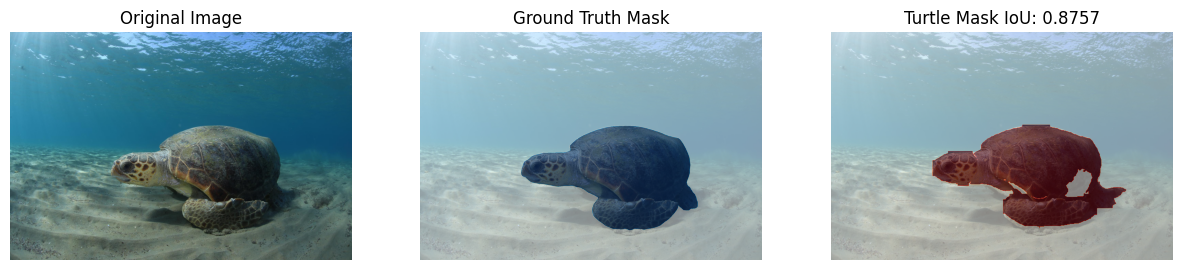

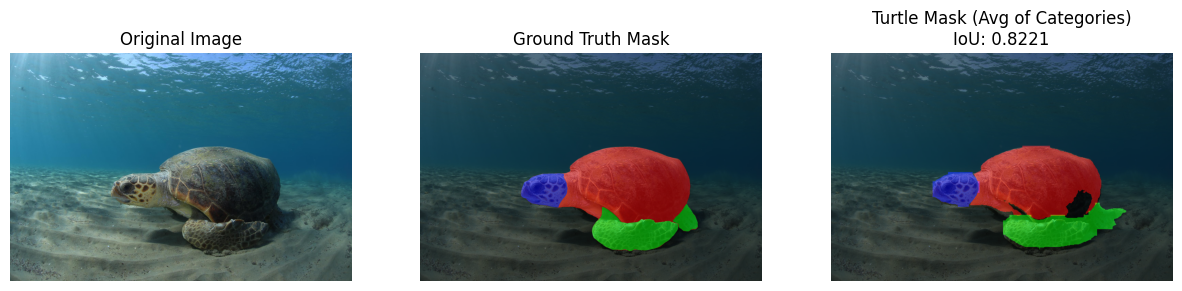

Processed Image Id: 8234; Head IoU = 0.8929, Flippers IoU = 0.7099, Carapace IoU = 0.8634, Turtle IoU = 0.8757, Avg IoU (3 categories) 0.8221

Mean IoUs:
Head: 0.8719
Flippers: 0.7122
Carapace: 0.8074
Turtle: 0.8872
Avg IoU (3 Categories): 0.7972


In [ ]:

# Function to display Predicted results and calculate IoU scores
def predict_and_display_miou_results(test_df, model_path, coco_data, test_dir):

    # Load the YOLO model
    model = YOLO(model_path)

    # Function to calculate IoU on predicted and true masks
    def calculate_iou(pred_mask, true_mask):
        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()
        return intersection / union if union > 0 else 0

    # Function To Display Mask Overlay on original image
    def plot_mask_overlay(image, pred_mask, true_mask, title):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.imshow(true_mask, alpha=0.5, cmap="Blues")
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.imshow(pred_mask, alpha=0.5, cmap="Reds")
        plt.title(title)
        plt.axis('off')
        plt.show()

    # Lists to hold IoU values
    head_ious, flippers_ious, carapace_ious, turtle_ious, avg_ious = [], [], [], [], []
    iou_results = []

    # Process each image in the test dataset
    for idx, img_data in test_df.iterrows():
        img_id = img_data['id']
        img_name = img_data['file_name'].split('/')[-1]
        img_path = os.path.join(test_dir, img_name)
        img_shape = (img_data['height'], img_data['width'])


        # Load the image and ground-truth masks
        image = cv2.imread(img_path)
        anns = coco_data.loadAnns(coco_data.getAnnIds(imgIds=img_id, iscrowd=None))

        # Initialize true masks
        true_head_mask = np.zeros(img_shape, dtype=np.uint8)
        true_flippers_mask = np.zeros(img_shape, dtype=np.uint8)
        true_turtle_mask = np.zeros(img_shape, dtype=np.uint8)

        for ann in anns:
            mask = coco_data.annToMask(ann)
            mask_resized = cv2.resize(mask, (img_shape[1], img_shape[0]), interpolation=cv2.INTER_NEAREST)
            if ann['category_id'] == 3:  # Head
                true_head_mask |= mask_resized
            elif ann['category_id'] == 2:  # Flippers
                true_flippers_mask |= mask_resized
            elif ann['category_id'] == 1:  # Turtle
                true_turtle_mask |= mask_resized

        true_carapace_mask = true_turtle_mask & ~(true_head_mask | true_flippers_mask)

        # YOLO prediction
        results = model.predict(img_path)
        pred_head_mask, pred_flippers_mask, pred_carapace_mask = np.zeros(img_shape, dtype=np.uint8), np.zeros(img_shape, dtype=np.uint8), np.zeros(img_shape, dtype=np.uint8)

        for result in results:
            if result.masks is None or result.masks.data is None:
                continue
            masks = result.masks.data.cpu().numpy()
            categories = result.boxes.cls.cpu().numpy()

            for mask, category_id in zip(masks, categories):
                mask_resized = cv2.resize(mask, (img_shape[1], img_shape[0])) > 0.5
                if category_id == 2:
                    pred_head_mask |= mask_resized
                elif category_id == 1:
                    pred_flippers_mask |= mask_resized
                elif category_id == 0:
                    pred_carapace_mask |= mask_resized

        pred_turtle_mask = pred_head_mask | pred_flippers_mask | pred_carapace_mask

        # IoU calculation
        head_iou = calculate_iou(pred_head_mask, true_head_mask)
        flippers_iou = calculate_iou(pred_flippers_mask, true_flippers_mask)
        carapace_iou = calculate_iou(pred_carapace_mask, true_carapace_mask)
        turtle_iou = calculate_iou(pred_turtle_mask, true_turtle_mask)
        avg_iou = (head_iou + flippers_iou + carapace_iou) / 3

        head_ious.append(head_iou)
        flippers_ious.append(flippers_iou)
        carapace_ious.append(carapace_iou)
        turtle_ious.append(turtle_iou)
        avg_ious.append(avg_iou)

        # Combine Masks into a single image
        overall_mask = np.zeros((pred_carapace_mask.shape[0], pred_carapace_mask.shape[1], 3), dtype=np.uint8)
        overall_mask[:,:,0] = (pred_carapace_mask * 255).astype(np.uint8)
        overall_mask[:,:,1] =  (pred_flippers_mask * 255).astype(np.uint8)
        overall_mask[:,:,2] = (pred_head_mask * 255).astype(np.uint8)

        overall_true_mask = np.zeros((true_head_mask.shape[0], true_head_mask.shape[1], 3), dtype=np.uint8)
        overall_true_mask[:,:,0] = (true_carapace_mask * 255).astype(np.uint8)
        overall_true_mask[:,:,1] = (true_flippers_mask * 255).astype(np.uint8)
        overall_true_mask[:,:,2] = (true_head_mask * 255).astype(np.uint8)

        # Plot the mask overlays
        plot_mask_overlay(image, pred_head_mask, true_head_mask, f"Head Mask IoU: {head_iou:.4f}")
        plot_mask_overlay(image, pred_flippers_mask, true_flippers_mask, f"Flippers Mask IoU: {flippers_iou:.4f}")
        plot_mask_overlay(image, pred_carapace_mask, true_carapace_mask, f"Carapace Mask IoU: {carapace_iou:.4f}")
        plot_mask_overlay(image, pred_turtle_mask, true_turtle_mask, f"Turtle Mask IoU: {turtle_iou:.4f}")
        plot_mask_overlay(image, overall_mask, overall_true_mask, f"Turtle Mask (Avg of Categories)\nIoU: {avg_iou:.4f}")

        # Save individual image IoUs
        iou_results.append({
            'image_id': img_id,
            'image_name': img_name,
            'head_iou': head_iou,
            'flipper_iou': flippers_iou,
            'carapace_iou': carapace_iou,
            'turtle_iou': turtle_iou,
            'avg_iou (3 categories)': avg_iou
        })

        print(f"Processed Image Id: {img_id}; Head IoU = {head_iou:.4f}, Flippers IoU = {flippers_iou:.4f}, Carapace IoU = {carapace_iou:.4f}, Turtle IoU = {turtle_iou:.4f}, Avg IoU (3 categories) {avg_iou:.4f}")

    # Calculate and display mean IoUs for each category and the Entire turtle
    head_miou = np.mean(head_ious)
    flippers_miou = np.mean(flippers_ious)
    carapace_miou = np.mean(carapace_ious)
    turtle_miou = np.mean(turtle_ious)
    avg_mious = np.mean(avg_ious)

    print(f"\nMean IoUs:")
    print(f"Head: {head_miou:.4f}")
    print(f"Flippers: {flippers_miou:.4f}")
    print(f"Carapace: {carapace_miou:.4f}")
    print(f"Turtle: {turtle_miou:.4f}")
    print(f"Avg IoU (3 Categories): {avg_mious:.4f}")

    # Return results and means
    results_df = pd.DataFrame(iou_results)
    return head_miou, flippers_miou, carapace_miou, turtle_miou, avg_mious, results_df


# Call the function to form predictions on given test ids
yolo_head_miou, yolo_flippers_miou, yolo_carapace_miou, yolo_turtle_miou, yolo_avg_mious, yolo_results_df = predict_and_display_miou_results(
    sample_test_df , yolo_model_path, coco, test_img_path
)




Run this cell only if you want to predict yolo on the whole test set

In [ ]:
# Function to display Predicted results and calculate IoU scores for Entire Test Set
def predict_alltest_miou_results(test_df, model_path, coco_data, test_dir):

    # Load the YOLO model
    model = YOLO(model_path)

    # Function to calculate IoU on predicted and true masks
    def calculate_iou(pred_mask, true_mask):
        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()
        return intersection / union if union > 0 else 0

    # Lists to hold IoU values
    head_ious, flippers_ious, carapace_ious, turtle_ious, avg_ious = [], [], [], [], []
    iou_results = []

    # Process each image in the test dataset
    for idx, img_data in test_df.iterrows():
        img_id = img_data['id']
        img_name = img_data['file_name'].split('/')[-1]
        img_path = os.path.join(test_dir, img_name)
        img_shape = (img_data['height'], img_data['width'])


        # Load the image and ground-truth masks
        image = cv2.imread(img_path)
        anns = coco_data.loadAnns(coco_data.getAnnIds(imgIds=img_id, iscrowd=None))

        # Initialize true masks
        true_head_mask = np.zeros(img_shape, dtype=np.uint8)
        true_flippers_mask = np.zeros(img_shape, dtype=np.uint8)
        true_turtle_mask = np.zeros(img_shape, dtype=np.uint8)

        for ann in anns:
            mask = coco_data.annToMask(ann)
            mask_resized = cv2.resize(mask, (img_shape[1], img_shape[0]), interpolation=cv2.INTER_NEAREST)
            if ann['category_id'] == 3:  # Head
                true_head_mask |= mask_resized
            elif ann['category_id'] == 2:  # Flippers
                true_flippers_mask |= mask_resized
            elif ann['category_id'] == 1:  # Turtle
                true_turtle_mask |= mask_resized

        true_carapace_mask = true_turtle_mask & ~(true_head_mask | true_flippers_mask)

        # YOLO prediction
        results = model.predict(img_path)
        pred_head_mask, pred_flippers_mask, pred_carapace_mask = np.zeros(img_shape, dtype=np.uint8), np.zeros(img_shape, dtype=np.uint8), np.zeros(img_shape, dtype=np.uint8)

        for result in results:
            if result.masks is None or result.masks.data is None:
                continue
            masks = result.masks.data.cpu().numpy()
            categories = result.boxes.cls.cpu().numpy()

            for mask, category_id in zip(masks, categories):
                mask_resized = cv2.resize(mask, (img_shape[1], img_shape[0])) > 0.5
                if category_id == 2:
                    pred_head_mask |= mask_resized
                elif category_id == 1:
                    pred_flippers_mask |= mask_resized
                elif category_id == 0:
                    pred_carapace_mask |= mask_resized

        pred_turtle_mask = pred_head_mask | pred_flippers_mask | pred_carapace_mask

        # IoU calculation
        head_iou = calculate_iou(pred_head_mask, true_head_mask)
        flippers_iou = calculate_iou(pred_flippers_mask, true_flippers_mask)
        carapace_iou = calculate_iou(pred_carapace_mask, true_carapace_mask)
        turtle_iou = calculate_iou(pred_turtle_mask, true_turtle_mask)
        avg_iou = (head_iou + flippers_iou + carapace_iou) / 3

        head_ious.append(head_iou)
        flippers_ious.append(flippers_iou)
        carapace_ious.append(carapace_iou)
        turtle_ious.append(turtle_iou)
        avg_ious.append(avg_iou)

        # Combine Masks into a single image
        overall_mask = np.zeros((pred_carapace_mask.shape[0], pred_carapace_mask.shape[1], 3), dtype=np.uint8)
        overall_mask[:,:,0] = (pred_carapace_mask * 255).astype(np.uint8)
        overall_mask[:,:,1] =  (pred_flippers_mask * 255).astype(np.uint8)
        overall_mask[:,:,2] = (pred_head_mask * 255).astype(np.uint8)

        overall_true_mask = np.zeros((true_head_mask.shape[0], true_head_mask.shape[1], 3), dtype=np.uint8)
        overall_true_mask[:,:,0] = (true_carapace_mask * 255).astype(np.uint8)
        overall_true_mask[:,:,1] = (true_flippers_mask * 255).astype(np.uint8)
        overall_true_mask[:,:,2] = (true_head_mask * 255).astype(np.uint8)

        # Save individual image IoUs
        iou_results.append({
            'image_id': img_id,
            'image_name': img_name,
            'head_iou': head_iou,
            'flipper_iou': flippers_iou,
            'carapace_iou': carapace_iou,
            'turtle_iou': turtle_iou,
            'avg_iou (3 categories)': avg_iou
        })

        print(f"Processed Image Id: {img_id}; Head IoU = {head_iou:.4f}, Flippers IoU = {flippers_iou:.4f}, Carapace IoU = {carapace_iou:.4f}, Turtle IoU = {turtle_iou:.4f}, Avg IoU (3 categories) {avg_iou:.4f}")

    # Calculate and display mean IoUs for each category and the Entire turtle
    head_miou = np.mean(head_ious)
    flippers_miou = np.mean(flippers_ious)
    carapace_miou = np.mean(carapace_ious)
    turtle_miou = np.mean(turtle_ious)
    avg_mious = np.mean(avg_ious)

    print(f"\nMean IoUs:")
    print(f"Head: {head_miou:.4f}")
    print(f"Flippers: {flippers_miou:.4f}")
    print(f"Carapace: {carapace_miou:.4f}")
    print(f"Turtle: {turtle_miou:.4f}")
    print(f"Avg IoU (3 Categories): {avg_mious:.4f}")

    # Return results and means
    results_df = pd.DataFrame(iou_results)
    return head_miou, flippers_miou, carapace_miou, turtle_miou, avg_mious, results_df


# Call the function to form predictions on entire test set.
yolo_head_miou, yolo_flippers_miou, yolo_carapace_miou, yolo_turtle_miou, yolo_avg_mious, yolo_results_df = predict_alltest_miou_results(
    test_df , yolo_model_path, coco, test_img_path
)




In [ ]:
yolo_results_df

image_id       image_name  head_iou  flipper_iou  carapace_iou  turtle_iou  \
0      7878  aPUsIpzHru.jpeg  0.850988     0.714496      0.751461    0.898709   
1      8234  iOHuUaZNtV.jpeg  0.892894     0.709944      0.863379    0.875703   

   avg_iou (3 categories)  
0                0.772315  
1                0.822072

# UNet

In [ ]:
!pip install "tensorflow<=2.13"

In [ ]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [ ]:

import os
import cv2
import glob
import json
import pandas as pd
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
from tqdm import tqdm
# import skimage.io as io
from matplotlib import pyplot as plt
from pprint import pprint
import tensorflow as tf
from tensorflow.keras import regularizers
# import tensorflow_addons as tfa
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation, Layer, Concatenate, Lambda, Add, Multiply

%matplotlib inline

In [ ]:
base_path = "/content/drive/MyDrive/data/"

coco = COCO(f'{base_path}annotations.json')
# Get all image IDs and categories
image_ids = coco.getImgIds()
cat_ids = coco.getCatIds()

# Create List of all Category ids and Image ids
cat_list = coco.loadCats(cat_ids)

img_list = coco.loadImgs(image_ids)

def plot_segmentation_overlay(image, mask, class_labels=['body', 'flippers', 'head'], alpha=0.5, ax = None, is_mask_rgb=False, show=True):
    """
    Overlays a multiclass segmentation mask over an image.
    Parameters:
        image (np.ndarray): The RGB image array of shape (H, W, 3).
        mask (np.ndarray): The segmentation mask array of shape (H, W, 3) if is_mask_rgb=True.
        class_labels (list): List of labels for each class, for the legend.
        alpha (float): Opacity level for the overlay (0 is transparent, 1 is opaque).
        is_mask_rgb (bool): Whether the mask is already in RGB format.
    """

    category_colors = {
        1: np.array([1, 0, 0]),
        2: np.array([0, 1, 0]),
        3: np.array([0, 0, 1])
    }


    if mask.shape[-1] == 4:
        mask = mask[:,:,:3]
    mask_rgb = np.zeros_like(mask, dtype=np.float32)
    for i, color in category_colors.items():
        # Apply each color to its corresponding mask channel
        mask += mask[:, :, i-1:i] * color.reshape(1, 1, 3)
    # Overlay mask on image
    overlay = (1 - alpha) * image + alpha * mask

    # Plotting
    if ax == None:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image)
    ax.imshow(mask, alpha=alpha)
    ax.axis('off')

    # Add a legend if class labels are provided
    if class_labels:
        handles = [
            plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=category_colors[i+1], markersize=10)
            for i in range(3)
        ]
        ax.legend(handles, class_labels, loc="upper right", title="Classes",
                 bbox_to_anchor=(1.2, 1))
    if show:
        plt.show()


loading annotations into memory...
Done (t=11.05s)
creating index...
index created!


## Data Loading

In [ ]:

metadata = pd.read_csv(f'{base_path}metadata_splits.csv')
test_ids = metadata['id'][metadata['split_open'] == 'test']
del metadata

def preprocess(image, dim=(256,256), normalize=True):
    # Resize
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    # Normalize
    if normalize:
        image = image.astype('float32') / 255.0
    return image

def getImageMask(image_id):
    global base_path
    img_dir = base_path
    img = coco.imgs[image_id]
    image = np.array(cv2.imread(img_dir+img['file_name']))
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)

    mask = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float32)

    for i in range(0,len(anns)):
        category = anns[i]['category_id']
        mask[:, :, category-1] += coco.annToMask(anns[i])
    for i in range(1, 3):
        overlap = mask[:, :, 0] * mask[:, :, i]
        # Remove overlap from current layer using a threshold
        mask[:, :, 0] = np.where(overlap, 0, mask[:, :, 0])

    mask_layer0 = (mask[:, :, 0] * 255).astype(np.uint8)

    # Using erosion followed by dilation (Opening)
    kernel = np.ones((3,3), np.uint8)
    mask_layer0 = cv2.morphologyEx(mask_layer0, cv2.MORPH_OPEN, kernel)
    mask[:, :, 0] = mask_layer0.astype(float) / 255.0

    image = preprocess(image)
    mask = preprocess(mask, normalize=False)
    return image, mask

def prepare_data(image, mask):
    """
    Prepare both main and auxiliary masks for a single sample
    """
    # Ensure shapes
    image = tf.ensure_shape(image, (256, 256, 3))
    mask = tf.ensure_shape(mask, (256, 256, 3))

    # Create auxiliary mask (binary foreground/background)
    aux_mask = tf.reduce_sum(mask, axis=-1, keepdims=True)
    aux_mask = tf.cast(aux_mask > 0, tf.float32)

    # Return image and both masks
    return image, {'main_output': mask, 'aux_output': aux_mask}

def load_data(ids, num_processes=8):

    all_images = []
    all_masks = []
    for id in tqdm(ids):
        image, mask = getImageMask(id)
        all_images.append(image)
        all_masks.append(mask)

    # Convert lists to numpy arrays
    all_images = np.array(all_images)
    all_masks = np.array(all_masks)

    # Convert data to TensorFlow tensors
    all_images = tf.convert_to_tensor(all_images, dtype=tf.float32)
    all_masks = tf.convert_to_tensor(all_masks, dtype=tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((all_images, all_masks))
    dataset = dataset.map(prepare_data)
    batch_size=8
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [ ]:
# Test on the same set of IDs as Yolo
test_dataset = load_data(test_img_ids)

# Uncomment is want to test on the entire test Dataset
# test_dataset = load_data(test_ids)

100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


## Model Definition

In [ ]:
class SpatialAttention(Layer):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        # Channel-wise average and max pooling
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)

        # Concatenate along the channel axis
        concat = Concatenate(axis=-1)([avg_pool, max_pool])

        # Apply convolution and sigmoid activation to get the attention map
        attention_map = self.conv(concat)

        # Multiply the attention map with the input feature map
        output = inputs * (attention_map *2)
        return output

class ThresholdLayer(tf.keras.layers.Layer):
    def __init__(self, threshold=0.5, **kwargs):
        super(ThresholdLayer, self).__init__(**kwargs)
        self.threshold = threshold

    def call(self, inputs):
        # Only apply thresholding during inference, not during training
        if not self.trainable:
            return tf.cast(inputs > self.threshold, inputs.dtype)
        return inputs
    def get_config(self):
        config = super().get_config()
        config.update({
            "threshold": self.threshold
        })
        return config

def attention_gate(x, g, filters):
    """
    Attention gate to focus on relevant features
    x: Skip connection input
    g: Gating signal (from upper layer)
    """
    theta_x = Conv2D(filters, (1, 1), padding='same')(x)
    phi_g = Conv2D(filters, (1, 1), padding='same')(g)

    f = Activation('relu')(Add()([theta_x, phi_g]))
    psi_f = Conv2D(1, (1, 1), padding='same')(f)
    rate = Activation('sigmoid')(psi_f)

    return Multiply()([x, rate])

def temperature_scale(logits, temperature=2.0):
    return logits / temperature


In [ ]:
def unet_model(input_shape, output_channels):
    inputs = Input(input_shape)
    dropout_rate = 0.35
    lambda_reg = 0.03
    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(inputs)
    s1 = SpatialAttention()(c1)
    c1 = Conv2D(32, (2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(s1)
    p1 = MaxPool2D((2, 2))(c1)  # Use (2, 2) pooling
    n1 = BatchNormalization()(p1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(n1)
    s2 = SpatialAttention()(c2)
    c2 = Conv2D(64, (2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(s2)

    p2 = MaxPool2D((2, 2))(c2)  # Use (2, 2) pooling

    n2 = BatchNormalization()(p2)
    # d1 = Dropout(dropout_rate)(p2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(n2)
    s3 = SpatialAttention()(c3)
    c3 = Conv2D(128, (2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(s3)
    p3 = MaxPool2D((2, 2))(c3)  # Use (2, 2) pooling

    n3 = BatchNormalization()(p3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(n3)
    s4 = SpatialAttention()(c4)
    c4 = Conv2D(256, (2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(s4)
    p4 = MaxPool2D((2, 2))(c4)  # Use (2, 2) pooling

    n4 = BatchNormalization()(p4)
    # d2 = Dropout(dropout_rate)(p4)

    # Bottleneck
    b5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(n4)
    s5 = SpatialAttention()(b5)
    b5 = Conv2D(512, (2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(s5)

    n5 = BatchNormalization()(b5)

    # Decoder
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(n5)
    g1 = attention_gate(c4, u6, 256)
    u6 = concatenate([u6, g1])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(u6)
    s6 = SpatialAttention()(c6)
    c6 = Conv2D(256, (2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(s6)
    n6 = BatchNormalization()(c6)

    # d3 = Dropout(dropout_rate)(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(n6)
    g2 = attention_gate(c3, u7, 128)
    u7 = concatenate([u7, g2])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(u7)
    s7 = SpatialAttention()(c7)
    c7 = Conv2D(128, (2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(s7)

    n7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(n7)
    g3 = attention_gate(c2, u8, 64)
    u8 = concatenate([u8, g3])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(u8)
    s8 = SpatialAttention()(c8)
    c8 = Conv2D(64, (2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(s8)

    n8 = BatchNormalization()(c8)

    # d4 = Dropout(dropout_rate)(c8)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(n8)
    g4 = attention_gate(c1, u9, 32)
    u9 = concatenate([u9, g4])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(u9)
    s9 = SpatialAttention()(c9)
    c9 = Conv2D(32, (2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg))(s9)

    n9 = BatchNormalization()(c9)

    # Output layer
    output = Conv2D(output_channels, (1, 1))(n9)
    output = Lambda(lambda x: temperature_scale(x, temperature=2.0))(output)
    main_output = Activation('softmax', name='main_output')(output)

     # Auxiliary branch for foreground-background separation
    aux_output = Conv2D(64, (3, 3), padding='same')(n9)
    aux_output = BatchNormalization()(aux_output)
    aux_output = Activation('relu')(aux_output)
    aux_output = Conv2D(1, (1, 1))(aux_output)
    aux_output = Activation('sigmoid', name='aux_output')(aux_output)

    model = Model(inputs, outputs=[main_output, aux_output])
    return model



In [ ]:
model = unet_model((256,256, 3), 3)
try:
    model.load_weights(f"{base_path}UNet_Model.keras")
except:
    model.load_weights(f"UNet_Model.keras")

## Testing

In [ ]:
def clean_binary_mask(mask, min_size=100, kernel_size=3, fill_holes=True, only_morphology=False):
    """
    Clean binary mask by removing small objects and filling holes using OpenCV.

    Parameters:
        mask: Binary mask (2D numpy array)
        min_size: Minimum size of objects to keep (in pixels)
        kernel_size: Size of kernel for morphological operations
        fill_holes: Whether to fill holes in objects

    Returns:
        cleaned_mask: Cleaned binary mask
    """
    # Ensure mask is binary and uint8
    mask = (mask > 0).astype(np.uint8)

    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply morphological opening to remove small noise
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    if only_morphology:
        return opened

    if fill_holes:
        # Fill holes using morphological operations
        # Get inverted mask
        inv_mask = cv2.bitwise_not(opened)

        # Flood fill from point (0,0)
        h, w = inv_mask.shape
        flood_mask = np.zeros((h+2, w+2), np.uint8)
        cv2.floodFill(inv_mask, flood_mask, (0,0), 255)

        # Invert floodfilled image
        inv_floodfill = cv2.bitwise_not(inv_mask)

        # Combine the two images to get the foreground
        opened = opened | inv_floodfill

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opened, connectivity=8)

    # Create cleaned mask
    cleaned_mask = np.zeros_like(mask)

    # Skip label 0 (background)
    for label in range(1, num_labels):
        size = stats[label, cv2.CC_STAT_AREA]
        if size >= min_size:
            cleaned_mask[labels == label] = 1

    return cleaned_mask

def clean_batch_binary_mask(masks, min_size=100, kernel_size=3, fill_holes=True, only_morphology=False, predicted_masks=False):
    """
    Clean a batch of binary masks.

    Parameters:
        masks: Binary masks of shape (batch_size, height, width) or (batch_size, height, width, 1)
        min_size: Minimum size of objects to keep (in pixels)
        kernel_size: Size of kernel for morphological operations
        fill_holes: Whether to fill holes in objects
        only_morphology: If True, only apply morphological operations

    Returns:
        cleaned_masks: Cleaned binary masks
    """

    if len(masks.shape) == 4 and masks.shape[-1] == 1:
        masks = np.squeeze(masks, axis=-1)

    # Process each mask in the batch
    cleaned_masks = []
    for mask in masks:
        if predicted_masks:
            cleaned = remove_thin_border(mask)
        else:
            cleaned = clean_binary_mask(
                mask,
                min_size=min_size,
                kernel_size=kernel_size,
                fill_holes=fill_holes,
                only_morphology=only_morphology
            )
        cleaned_masks.append(cleaned)

    # Stack masks back together
    cleaned_masks = np.stack(cleaned_masks, axis=0)

    # Restore channel dimension if input had it
    if len(masks.shape) == 4:
        cleaned_masks = np.expand_dims(cleaned_masks, axis=-1)

    return cleaned_masks

def remove_thin_border(mask, min_size=100, kernel_size=3):
    """
    Remove thin lines and clean up binary mask.

    Parameters:
        mask: Binary mask (2D numpy array)
        min_size: Minimum size of objects to keep
        kernel_size: Size of kernel for morphological operations

    Returns:
        cleaned_mask: Cleaned binary mask without thin lines
    """

    # Create kernels for morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    # Apply erosion to remove thin lines
    mask[:,:,2] = cv2.erode(mask[:,:,2], kernel, iterations=1)


    return mask

In [ ]:
def make_prediction(images, num_classes=3):
    predictions = model.predict(images, verbose=0)
    main_preds = predictions[0]  # Main segmentation predictions
    aux_predicted_mask = predictions[1] # Aux segmentation predictions

    foreground_masks = clean_batch_binary_mask((aux_predicted_mask > 0.5).astype(np.float32), min_size=10)
    main_preds = clean_batch_binary_mask(main_preds, predicted_masks=True)
    main_preds = np.squeeze(main_preds)

    foreground_masks = np.expand_dims(foreground_masks, axis=-1)  # Shape: (B, H, W, 1)

    # Broadcast foreground mask to match main predictions
    foreground_masks = np.repeat(foreground_masks, num_classes, axis=-1)  # Shape: (B, H, W, C)

    final_pred_mask = main_preds*foreground_masks
    return final_pred_mask

In [ ]:
def calculate_class_wise_iou(y_true, y_pred, num_classes, threshold=0.5):
    """
    Calculate class-wise IOU scores for segmentation masks.

    Parameters:
        y_true: Ground truth masks, shape (H, W, num_classes)
        y_pred: Predicted masks, shape (H, W, num_classes)
        num_classes: Number of classes
        threshold: Threshold for converting probability maps to binary

    Returns:
        class_ious: Dictionary with class-wise IOU scores
        mean_iou: Mean IOU across all classes
    """

    if y_pred.dtype != np.uint8:
        y_pred = tf.cast(y_pred > threshold, tf.float32)
    if y_true.dtype != np.uint8:
        y_true = tf.cast(y_true, tf.float32)

    class_ious = {}
    class_names = ['body', 'flippers', 'head', 'turtle'][:num_classes]

    # Calculate IOU for each class
    for class_idx in range(num_classes):
        # Extract binary masks for current class
        y_true_class = y_true[..., class_idx]
        y_pred_class = y_pred[..., class_idx]

        # Calculate intersection and union
        intersection = tf.reduce_sum(y_true_class * y_pred_class)
        union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class) - intersection

        # Calculate IOU
        iou = tf.where(union > 0, intersection / union, tf.zeros_like(intersection))

        class_ious[class_names[class_idx]] = float(iou.numpy())

    # Calculate mean IOU
    mean_iou = np.mean(list(class_ious.values()))

    return class_ious, mean_iou

def evaluate_dataset(model, test_dataset, num_classes=4):
    """
    Evaluate model on test dataset and calculate class-wise IOU scores.

    Parameters:
        model: Trained model
        test_dataset: TensorFlow dataset containing test data
        num_classes: Number of classes

    Returns:
        average_ious: Dictionary with average IOU score for each class
        all_scores: List of IOU scores for each image
    """

    all_scores = []
    class_names = ['body', 'flippers', 'head', 'turtle'][:num_classes]
    total_ious = {name: 0.0 for name in class_names}
    count = 0


    print("\nEvaluating test dataset...")
    for images, masks in tqdm(test_dataset):

        predictions = model.predict(images, verbose=0)
        main_preds = predictions[0]
        aux_predicted_mask = predictions[1]

        foreground_masks = clean_batch_binary_mask((aux_predicted_mask > 0.5).astype(np.float32), min_size=50)
        main_preds = clean_batch_binary_mask(main_preds, predicted_masks=True)
        main_preds = np.squeeze(main_preds)

        # Add channel dimension to foreground masks for broadcasting
        foreground_masks = np.expand_dims(foreground_masks, axis=-1)  # Shape: (B, H, W, 1)

        # Broadcast foreground mask to match main predictions
        foreground_masks = np.repeat(foreground_masks, 3, axis=-1)  # Shape: (B, H, W, C)

        final_pred_mask = main_preds*foreground_masks

        final_pred_mask = np.concatenate([final_pred_mask, foreground_masks[..., 0:1]], axis=-1)

        for i in range(len(images)):
            y_true_class = masks['main_output'][i]
            y_true_turtle = masks['aux_output'][i]
            y_true_turtle = np.repeat(y_true_turtle, 3, axis=-1)

            y_true = np.concatenate([y_true_class, y_true_turtle[..., 0:1]], axis=-1)


            y_pred = final_pred_mask[i]

            # Calculate IOU scores for current image
            ious, mean_iou = calculate_class_wise_iou(y_true, y_pred, num_classes)
            all_scores.append(ious)

            # Update running totals
            for idx, class_name in enumerate(class_names):
                total_ious[class_name] += ious[class_name]

            count += 1

    # Calculate averages
    average_ious = {name: total_ious[name] / count for name in class_names}

    return average_ious, all_scores

def print_evaluation_results(average_ious, all_scores):
    """
    Print detailed evaluation results.

    Parameters:
        average_ious: Dictionary with average IOU score for each class
        all_scores: List of IOU scores for each image
    """
    print("\n" + "="*50)
    print("EVALUATION RESULTS")
    print("="*50)

    # Print average scores
    print("\nAverage IOU Scores:")
    mean_iou = 0
    mean_ious = {}
    for class_name, iou in average_ious.items():
        print(f"{class_name}: {iou:.4f}")
        mean_iou += iou
        mean_ious[class_name] = iou
    mean_iou = mean_iou/len(average_ious)

    print(f"\nMean IOU: {mean_iou}")

    # Calculate and print statistics
    print("\nClass-wise Statistics:")
    for class_name in average_ious.keys():
        class_scores = [scores[class_name]
                       for scores in all_scores]
        print(f"\n{class_name}:")
        print(f"├── Min: {min(class_scores):.4f}")
        print(f"├── Max: {max(class_scores):.4f}")
        print(f"├── Median: {np.median(class_scores):.4f}")
        print(f"└── Std: {np.std(class_scores):.4f}")
    return mean_ious

def save_evaluation_results(average_ious, all_scores, save_path):
    """
    Save evaluation results to file.

    Parameters:
        average_ious: Dictionary with average IOU score for each class
        all_scores: List of IOU scores for each image
        save_path: Path to save results
    """
    results = {
        'average_ious': average_ious,
        'all_scores': all_scores,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }

    # Save as JSON
    with open(save_path, 'w') as f:
        json.dump(results, f, indent=4)

    print(f"\nResults saved to: {save_path}")

# Entire test dataset Results
average_iou, all_scores = evaluate_dataset(model, test_dataset, num_classes=4)
mean_ious = print_evaluation_results(average_iou, all_scores)


Evaluating test dataset...


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


EVALUATION RESULTS

Average IOU Scores:
body: 0.8659
flippers: 0.6677
head: 0.8519
turtle: 0.9357

Mean IOU: 0.8302889093756676

Class-wise Statistics:

body:
├── Min: 0.7696
├── Max: 0.9623
├── Median: 0.8659
└── Std: 0.0963

flippers:
├── Min: 0.5916
├── Max: 0.7438
├── Median: 0.6677
└── Std: 0.0761

head:
├── Min: 0.8358
├── Max: 0.8680
├── Median: 0.8519
└── Std: 0.0161

turtle:
├── Min: 0.9023
├── Max: 0.9690
├── Median: 0.9357
└── Std: 0.0334


In [ ]:
def calculate_batch_iou(final_pred_mask, masks, num_classes=4):
    all_scores = []
    class_names = ['body', 'flippers', 'head', 'turtle'][:num_classes]
    total_ious = {name: 0.0 for name in class_names}
    for i in range(len(masks)):
        print(masks.shape)
        y_true_class = masks['main_output'][i]
        y_true_turtle = masks['aux_output'][i]
        y_true_turtle = np.repeat(y_true_turtle, 3, axis=-1)

        y_true = np.concatenate([y_true_class, y_true_turtle[..., 0:1]], axis=-1)


        y_pred = final_pred_mask[i]

        # Calculate IOU scores for current image
        ious, mean_iou = calculate_class_wise_iou(y_true, y_pred, num_classes)
        all_scores.append(ious)

        # Update running totals
        for idx, class_name in enumerate(class_names):
            total_ious[class_name] += ious[class_name]

        count += 1

    # Calculate averages
    average_ious = {name: total_ious[name] / count for name in class_names}

    return average_ious, all_scores

In [ ]:
good_img_ids = [8337, 8677,8382, 6842, 8677]
fail_test_ids = [5389,8364,6752,7694]  # Replace with actual image IDs final_pred_mask

In [ ]:
# average_iou, all_scores = evaluate_dataset(model, sample_test_data, num_classes=4)
# mean_ious = print_evaluation_results(average_iou, all_scores)

In [ ]:
def plot_mask_overlay(image, pred_mask, true_mask):
    plt.figure(figsize=(15, 5))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Display true mask overlay
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(true_mask, alpha=0.5, cmap="Blues")
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Display predicted mask overlay
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(pred_mask, alpha=0.5, cmap="Reds")
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

def test_ids(ids):
    image_batch = []
    mask_batch = []
    for id in ids:
        image, mask = getImageMask(id)
        image_batch.append(image)
        mask_batch.append(mask)

    image_batch = np.array(image_batch)
    mask_batch = np.array(mask_batch)

    predicted_masks_batch = make_prediction(image_batch)

    # average_iou, all_scores = calculate_batch_iou(predicted_masks_batch, mask_batch, num_classes=4)
    mean_iou = print_evaluation_results(average_iou, all_scores)
    for id in range(image_batch.shape[0]):
        plot_mask_overlay(image_batch[id], predicted_masks_batch[id], mask_batch[id])
    # return mean_iou


EVALUATION RESULTS

Average IOU Scores:
body: 0.8659
flippers: 0.6677
head: 0.8519
turtle: 0.9357

Mean IOU: 0.8302889093756676

Class-wise Statistics:

body:
├── Min: 0.7696
├── Max: 0.9623
├── Median: 0.8659
└── Std: 0.0963

flippers:
├── Min: 0.5916
├── Max: 0.7438
├── Median: 0.6677
└── Std: 0.0761

head:
├── Min: 0.8358
├── Max: 0.8680
├── Median: 0.8519
└── Std: 0.0161

turtle:
├── Min: 0.9023
├── Max: 0.9690
├── Median: 0.9357
└── Std: 0.0334


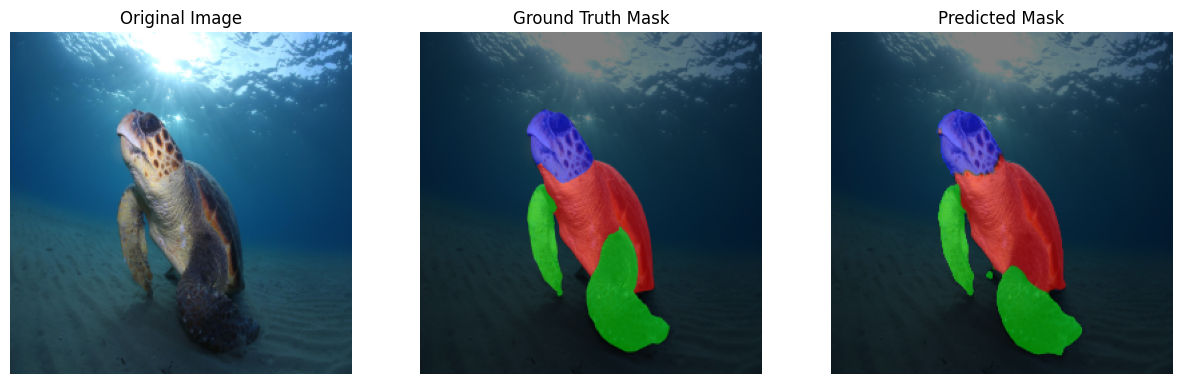

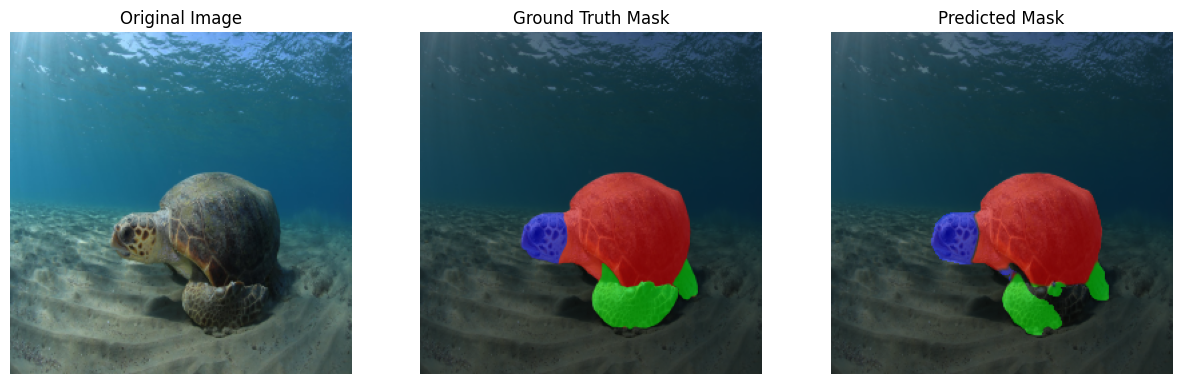

In [ ]:
# print(fail_test_ids)
test_ids(test_img_ids)

# YOLO and UNet Comparision
YOLO and UNet models are compared based on IoU scores

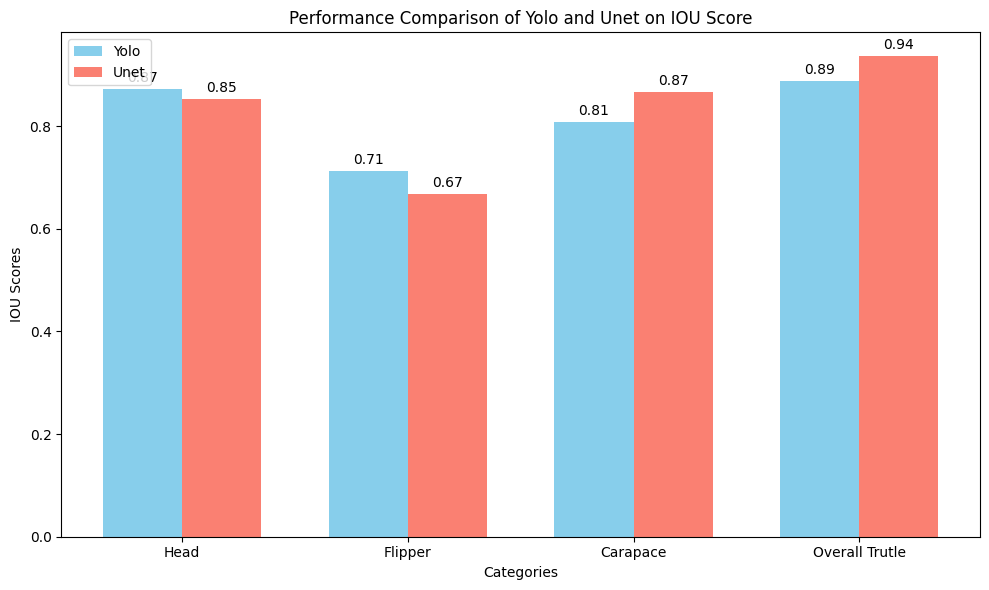

In [ ]:
# Plot Graph between Yolo and Unet IoU Scores

import numpy as np
import matplotlib.pyplot as plt

# Store Scores for the YOLO IOU
yolo_iou_score = []
yolo_iou_score.append(yolo_head_miou)
yolo_iou_score.append(yolo_flippers_miou)
yolo_iou_score.append(yolo_carapace_miou)
yolo_iou_score.append(yolo_turtle_miou)
# yolo_iou_score.append(yolo_avg_mious)

# Store Scores for Unet IOU
# unet_avg_miou =
unet_iou_score = []
# print(mean_ious)
unet_iou_score.append(mean_ious['head'])
unet_iou_score.append(mean_ious['flippers'])
unet_iou_score.append(mean_ious['body'])
unet_iou_score.append(mean_ious['turtle'])
# unet_iou_score.append(unet_avg_mious)

# Metric/Score labels for the graphs
metrics = ['Head', 'Flipper','Carapace', 'Overall Trutle']

# Set up bar locations and width
x = np.arange(len(metrics))
width = 0.35

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, yolo_iou_score, width, label='Yolo', color='skyblue')
rects2 = ax.bar(x + width/2, unet_iou_score, width, label='Unet', color='salmon')

# Set Labels and titles
ax.set_xlabel('Categories')
ax.set_ylabel('IOU Scores')
ax.set_title('Performance Comparison of Yolo and Unet on IOU Score')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add value labels above bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text above bars
                    textcoords="offset points",
                    ha='center', va='bottom')

# Apply labels to each set of bars
add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()
